https://www.kaggle.com/datasets/ealaxi/banksim1/data



# Dataset overview

We detect the fraudulent transactions from the Banksim dataset. This synthetically generated dataset consists of payments from various customers made in different time periods and with different amounts. The features are as follows:

- Step: This feature represents the day from the start of simulation. It has 180 steps so simulation ran for virtually 6 months.
- Customer: This feature represents the customer id
- zipCodeOrigin: The zip code of origin/source.
- Merchant: The merchant's id
- zipMerchant: The merchant's zip code
- Age: Categorized age
    - 0: <= 18,
    - 1: 19-25,
    - 2: 26-35,
    - 3: 36-45,
    - 4: 46-55,
    - 5: 56-65,
    - 6: > 65
    - U: Unknown
- Gender: Gender for customer
    - E : Enterprise,
    - F: Female,
    - M: Male,
    - U: Unknown
- Category: Category of the purchase. I won't write all categories here, we'll see them later in the analysis.
- Amount: Amount of the purchase
- Fraud: Target variable which shows if the transaction fraudulent(1) or benign(0)



# Import Libraries and Read Data

In [4]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

# Machine Learning and Data Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support, f1_score
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer

# Neural Networks and Tuning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner import HyperModel, Objective

# Configuration and Style
plt.style.use('ggplot')
warnings.simplefilter(action='ignore', category=FutureWarning)
start_time = time.time()


In [5]:
# Read in data files

file_path = '../data/fraud_dataset.csv'

df = pd.read_csv(file_path)
   
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


# EDA

In [7]:
# Check the size of the dataset
df_size = df.shape

# Summarize data types
df_data_types = df.dtypes

# Check for missing values
df_missing_values = df.isnull().sum()

# Basic statistical summary for numerical columns
df_statistical_summary = df.describe()

df_size, df_data_types, df_missing_values, df_statistical_summary


((594643, 10),
 step             int64
 customer        object
 age             object
 gender          object
 zipcodeOri      object
 merchant        object
 zipMerchant     object
 category        object
 amount         float64
 fraud            int64
 dtype: object,
 step           0
 customer       0
 age            0
 gender         0
 zipcodeOri     0
 merchant       0
 zipMerchant    0
 category       0
 amount         0
 fraud          0
 dtype: int64,
                 step         amount          fraud
 count  594643.000000  594643.000000  594643.000000
 mean       94.986827      37.890135       0.012108
 std        51.053632     111.402831       0.109369
 min         0.000000       0.000000       0.000000
 25%        52.000000      13.740000       0.000000
 50%        97.000000      26.900000       0.000000
 75%       139.000000      42.540000       0.000000
 max       179.000000    8329.960000       1.000000)

**Initial Dataset Analysis**:
- The dataset contains 594,643 transactions with 10 columns.
- There are no missing values in the dataset, which is excellent for data analysis.

**Data Types and Summary:**
- Numerical columns: step, amount, and fraud.
- Categorical columns: customer, age, gender, zipcodeOri, merchant, zipMerchant, category. These are all stored as object types and may need formatting for better analysis.
    
**Statistical Summary for Numerical Columns:**
- Step: Covers a range from 0 to 179, possibly days or time steps.
- Amount: The mean transaction amount is approximately 37.89, but there's a large range, suggesting variability in transaction sizes.
- Fraud: Only about 1.21% of transactions are fraudulent based on the mean of the fraud column.

**Initial Data Cleaning:**
- Drop Redundant Columns: zipcodeOri and zipMerchant have only one unique value ('28007') and can be removed.
- Format Cleaning: Remove quotes from string data in columns like customer, age, gender, merchant, and category.

In [10]:
# Drop redundant columns with only one unique value
df.drop(['zipcodeOri', 'zipMerchant'], axis=1, inplace=True)

# Clean up the data by removing quotes from string data
df['customer'] = df['customer'].str.strip("'")
df['age'] = df['age'].str.strip("'")
df['gender'] = df['gender'].str.strip("'")
df['merchant'] = df['merchant'].str.strip("'")
df['category'] = df['category'].str.strip("'")

# Display the cleaned dataframe to verify changes
df.head()


,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


The two zip code columns are constant for each value and thus provide no additional information.  These will be dropped.

## Target Variable

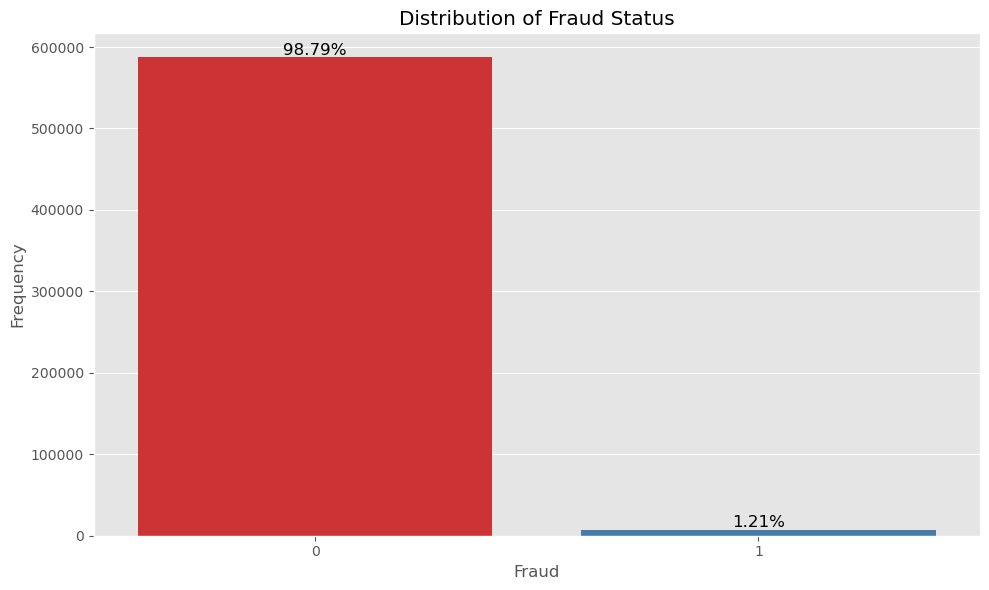

In [13]:
# Assume df is already loaded with your data
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment and adjust if the dataframe needs to be loaded

# Displaying the plot for fraud status
fig, ax = plt.subplots(figsize=(10, 6))

# Fraud distribution
count_plot = sns.countplot(x='fraud', data=df, ax=ax, palette='Set1')
ax.set_title('Distribution of Fraud Status')
ax.set_xlabel('Fraud')
ax.set_ylabel('Frequency')

# Calculate the total number of entries to get percentages
total = len(df['fraud'])

# Adding percentages above each bar
for p in count_plot.patches:
    height = p.get_height()
    count_plot.annotate(f'{100 * height / total:.2f}%', (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                        textcoords='offset points')

plt.tight_layout()
plt.show()



Target Variable:
- Fraud Status: This plot highlights the imbalance between fraudulent and non-fraudulent transactions, with non-fraudulent transactions significantly outnumbering fraudulent ones. Such an imbalance is typical in fraud detection scenarios and poses challenges in modeling and analysis.

## Univariate Analysis

### Numerical Columns

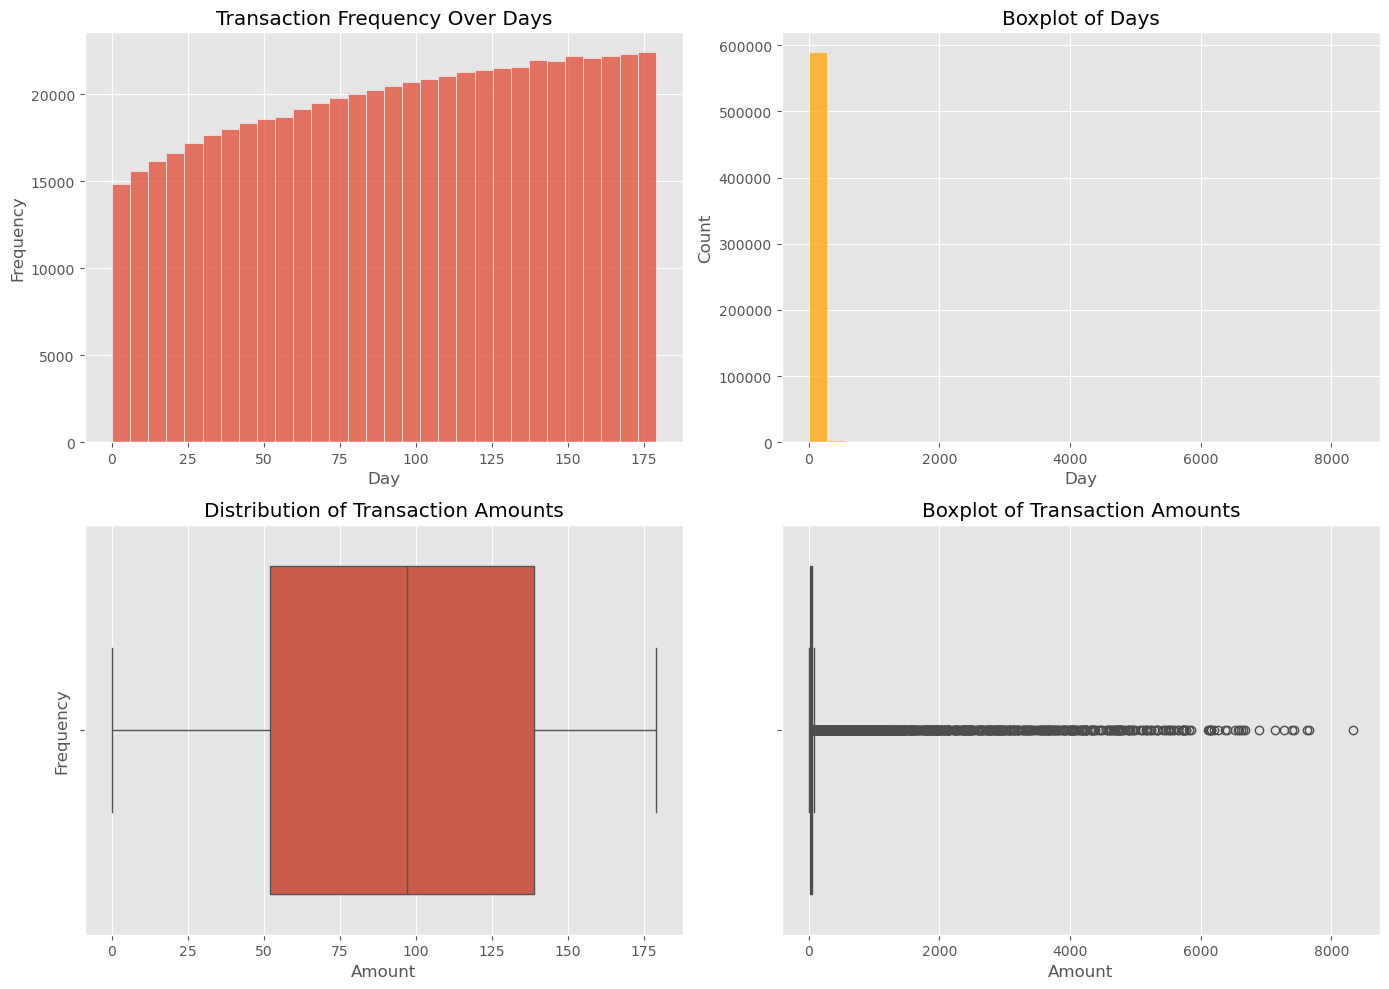

(count    594643.000000
 mean         94.986827
 std          51.053632
 min           0.000000
 25%          52.000000
 50%          97.000000
 75%         139.000000
 max         179.000000
 Name: step, dtype: float64,
 count    594643.000000
 mean         37.890135
 std         111.402831
 min           0.000000
 25%          13.740000
 50%          26.900000
 75%          42.540000
 max        8329.960000
 Name: amount, dtype: float64)

In [17]:
# Univariate Analysis for 'step' and 'amount'
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Histogram for 'step'
sns.histplot(df['step'], bins=30, kde=False, ax=ax[0, 0])
ax[0, 0].set_title('Transaction Frequency Over Days')
ax[0, 0].set_xlabel('Day')
ax[0, 0].set_ylabel('Frequency')

# Histogram for 'amount'
sns.histplot(df['amount'], bins=30, kde=False, ax=ax[0, 1], color='orange')
ax[1, 0].set_title('Distribution of Transaction Amounts')
ax[1, 0].set_xlabel('Amount')
ax[1, 0].set_ylabel('Frequency')

# Boxplot for 'step'
sns.boxplot(x=df['step'], ax=ax[1, 0])
ax[0, 1].set_title('Boxplot of Days')
ax[0, 1].set_xlabel('Day')

# Boxplot for 'amount'
sns.boxplot(x=df['amount'], ax=ax[1, 1], color='orange')
ax[1, 1].set_title('Boxplot of Transaction Amounts')
ax[1, 1].set_xlabel('Amount')

plt.tight_layout()
plt.show()

# Summary statistics for 'step' and 'amount'
step_summary = df['step'].describe()
amount_summary = df['amount'].describe()

step_summary, amount_summary


**Univariate Analysis Results - Numerical Columns**
- Step (Time):
    - Histogram: Transactions are relatively evenly distributed over the 180 days, with a slight increase in frequency towards the end. This suggests a stable usage pattern with some growth or seasonal effects.
    - Boxplot: Indicates that the df is uniformly distributed across the time frame, with no outliers.
    - Summary Statistics: 
        - Mean day is approximately 95 (middle of the 180-day period).  
        - Standard deviation of 51 days indicates a uniform spread throughout the period.
        
- Amount:
    - Histogram: The distribution of transaction amounts is heavily right-skewed, showing that most transactions are of lower value, with a few high-value outliers.
    - Boxplot: Confirms the presence of outliers with very high transaction amounts.
    - Summary Statistics: 
        - Mean transaction amount is approximately $37.89.
        - A high standard deviation ($111.40) relative to the mean suggests significant variability, primarily driven by outliers.
        - The median ($26.90) being lower than the mean also indicates a right-skewed distribution.

### Categorical Columnns

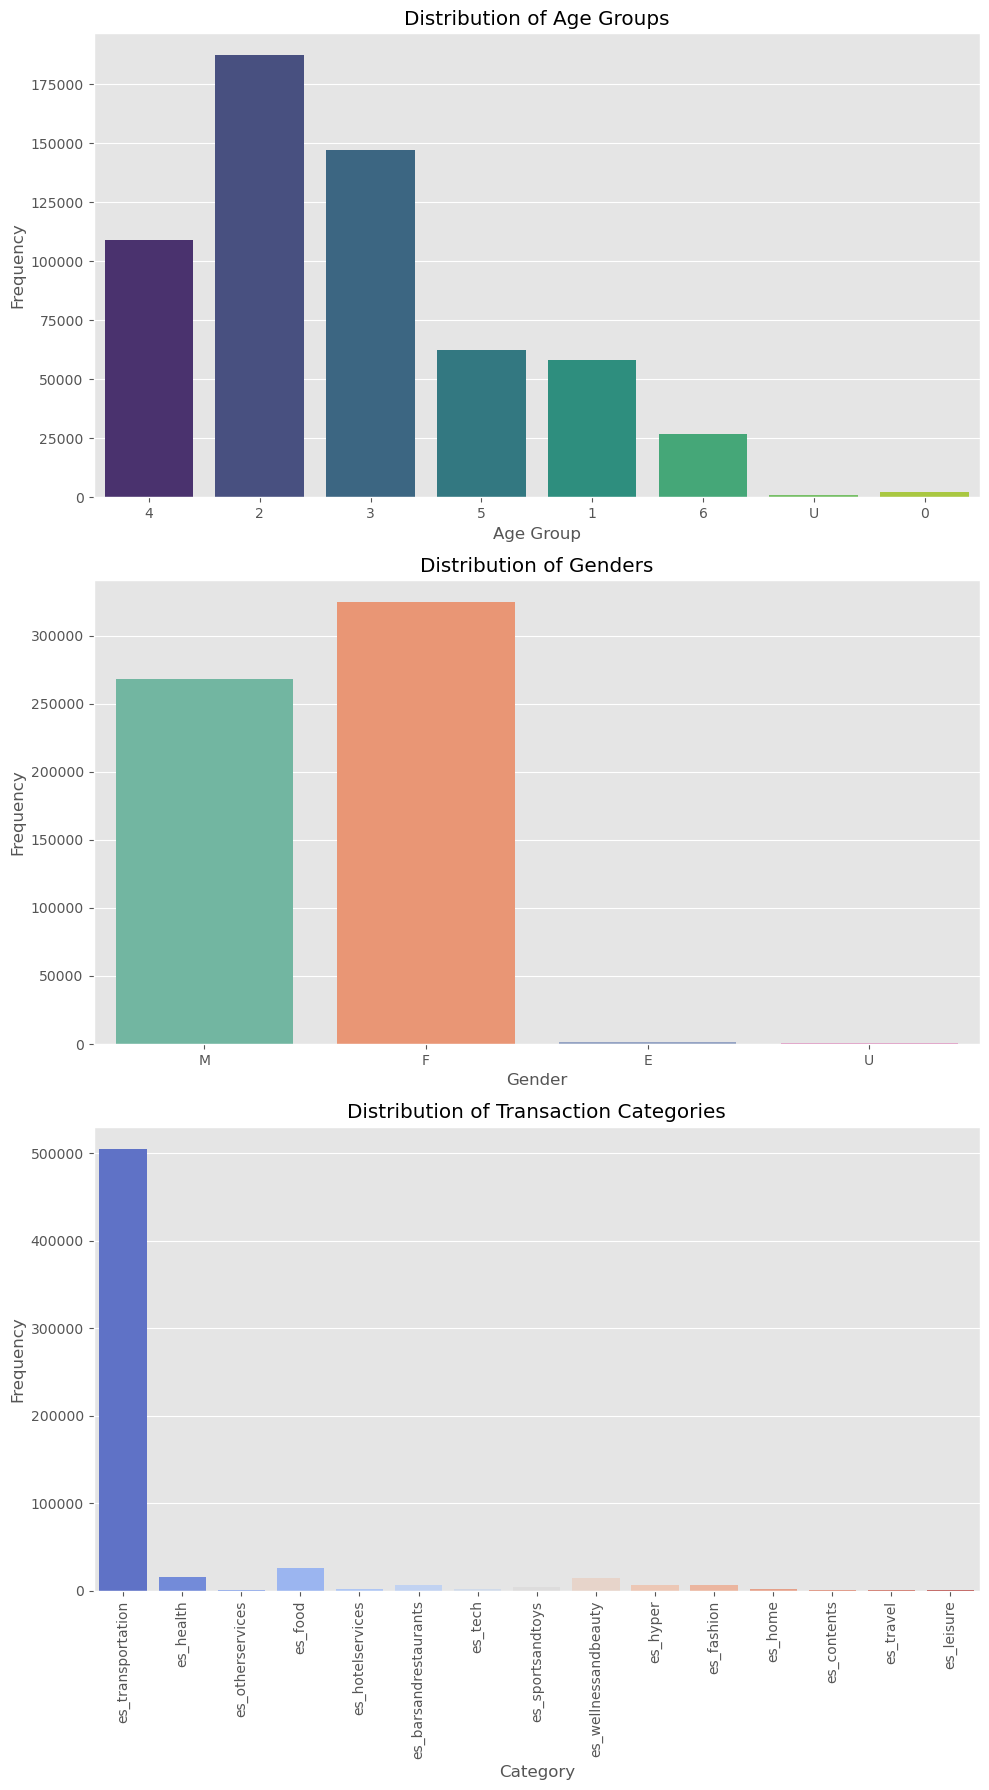

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume df is already loaded with your data
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment and adjust if the dataframe needs to be loaded

# Univariate Analysis for categorical variables
fig, ax = plt.subplots(3, 1, figsize=(10, 18))  # Adjusted subplot configuration to 3x1

# Age distribution
sns.countplot(x='age', data=df, ax=ax[0], palette='viridis')
ax[0].set_title('Distribution of Age Groups')
ax[0].set_xlabel('Age Group')
ax[0].set_ylabel('Frequency')

# Gender distribution
sns.countplot(x='gender', data=df, ax=ax[1], palette='Set2')
ax[1].set_title('Distribution of Genders')
ax[1].set_xlabel('Gender')
ax[1].set_ylabel('Frequency')

# Category distribution
sns.countplot(x='category', data=df, ax=ax[2], palette='coolwarm')
ax[2].set_title('Distribution of Transaction Categories')
ax[2].set_xlabel('Category')
ax[2].set_ylabel('Frequency')
ax[2].tick_params(axis='x', rotation=90)  # Rotating category labels for better readability

plt.tight_layout()
plt.show()



**Univariate Analysis Results - Categorical Columns**

- Age Group: Distribution shows that certain age groups are more prevalent in the dataset. This can help identify which groups are more active in transactions.
- Gender: The gender distribution helps understand the demographic split of the dataset users. There's a visible distribution between different genders which may influence transaction patterns.
- Transaction Categories: There's significant variation in the frequency of different transaction categories. Some categories are much more common, which may impact the focus of fraud detection strategies. Categories with fewer transactions but higher fraud rates could be particularly important.


Let's analyze the top merchants and customers in terms of transaction frequency and fraud incidence to identify any patterns or outliers. We'll focus on the top 10 merchants and customers based on the total number of transactions, and then examine their association with fraudulent transactions.


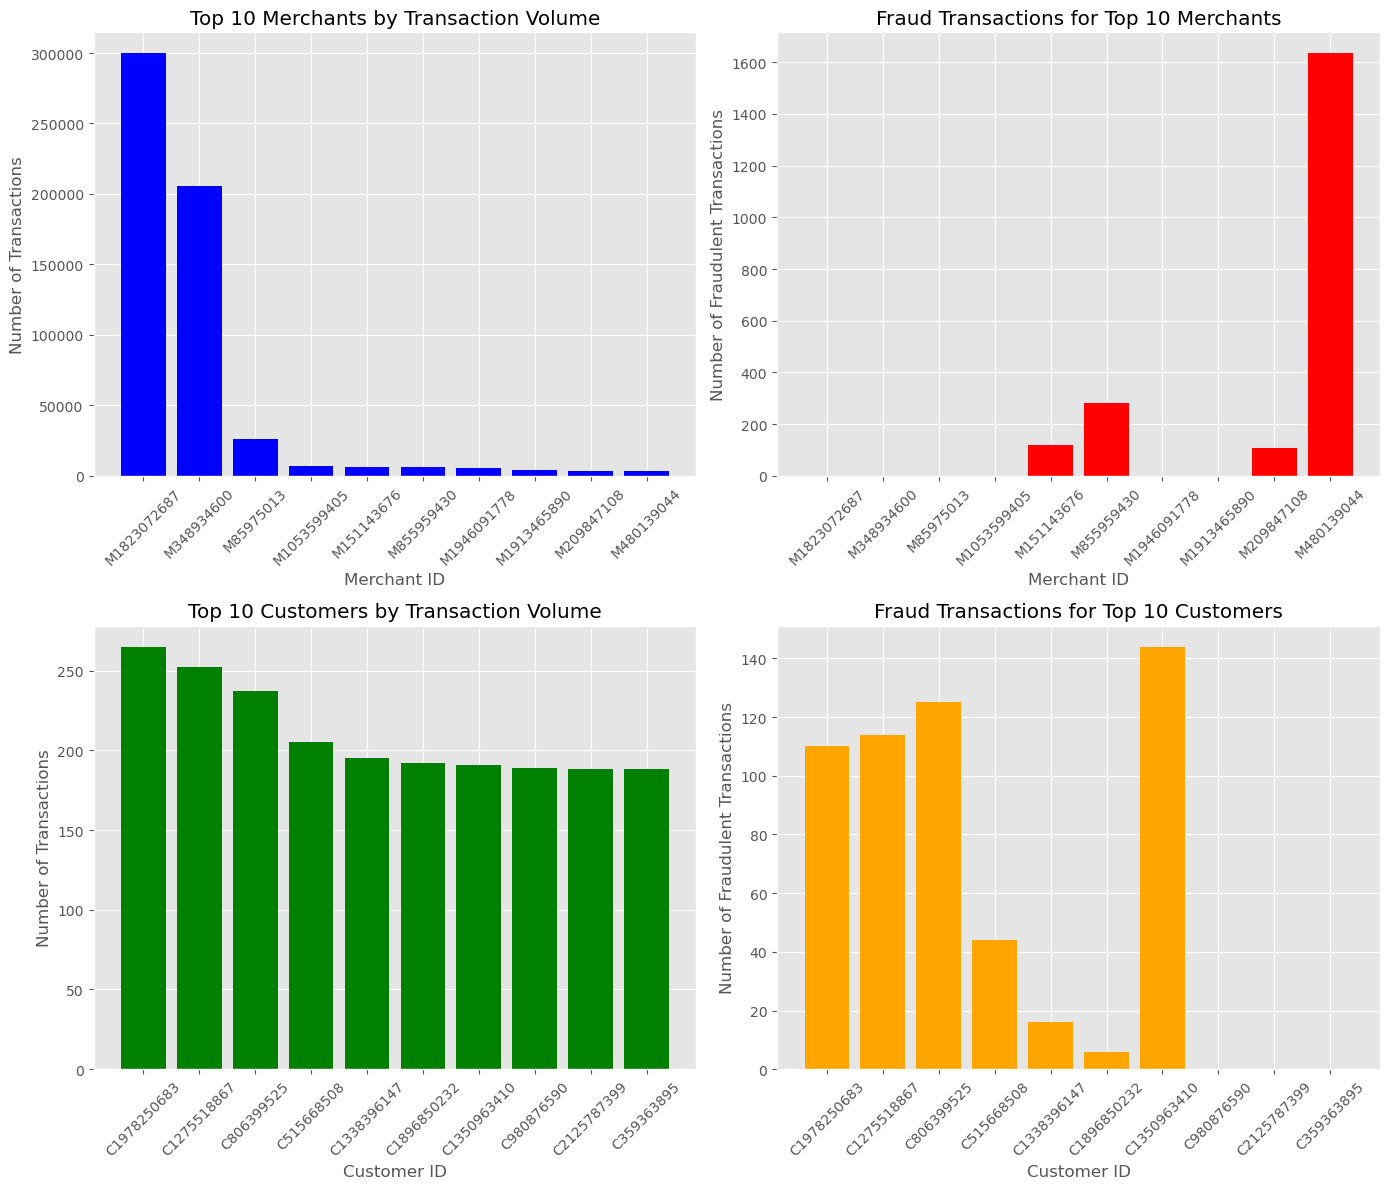

In [23]:
# Calculating the top 10 merchants and customers by transaction volume
top_merchants = df['merchant'].value_counts().head(10)
top_customers = df['customer'].value_counts().head(10)

# Calculating fraud incidences for top 10 merchants and customers
top_merchants_fraud = df[df['fraud'] == 1]['merchant'].value_counts().reindex(top_merchants.index, fill_value=0)
top_customers_fraud = df[df['fraud'] == 1]['customer'].value_counts().reindex(top_customers.index, fill_value=0)

# Plotting results
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Top 10 merchants by transaction volume
ax[0, 0].bar(top_merchants.index, top_merchants, color='blue')
ax[0, 0].set_title('Top 10 Merchants by Transaction Volume')
ax[0, 0].set_xlabel('Merchant ID')
ax[0, 0].set_ylabel('Number of Transactions')
ax[0, 0].tick_params(axis='x', rotation=45)

# Fraud transactions for top 10 merchants
ax[0, 1].bar(top_merchants_fraud.index, top_merchants_fraud, color='red')
ax[0, 1].set_title('Fraud Transactions for Top 10 Merchants')
ax[0, 1].set_xlabel('Merchant ID')
ax[0, 1].set_ylabel('Number of Fraudulent Transactions')
ax[0, 1].tick_params(axis='x', rotation=45)

# Top 10 customers by transaction volume
ax[1, 0].bar(top_customers.index, top_customers, color='green')
ax[1, 0].set_title('Top 10 Customers by Transaction Volume')
ax[1, 0].set_xlabel('Customer ID')
ax[1, 0].set_ylabel('Number of Transactions')
ax[1, 0].tick_params(axis='x', rotation=45)

# Fraud transactions for top 10 customers
ax[1, 1].bar(top_customers_fraud.index, top_customers_fraud, color='orange')
ax[1, 1].set_title('Fraud Transactions for Top 10 Customers')
ax[1, 1].set_xlabel('Customer ID')
ax[1, 1].set_ylabel('Number of Fraudulent Transactions')
ax[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Top 10 Merchants:
- Transaction Volume: The bar graph shows that some merchants have significantly higher transaction volumes than others.
- Fraud Incidences: For these top merchants, the number of fraudulent transactions varies. Some merchants have a relatively higher incidence of fraud, which could suggest areas where increased monitoring might be necessary.

Top 10 Customers:
- Transaction Volume: Similar to merchants, some customers engage in far more transactions than others, highlighting their potential influence or importance in the dataset.
- Fraud Incidences: The distribution of fraudulent transactions among these customers shows that fraud is not uniformly spread, indicating that certain customers might be more susceptible to fraud or involved in fraudulent activities.

Explore the zipcodeOri and zipMerchant to confirm if any variability exists.

## Bivariate Analysis

### Numerical vs Numerical

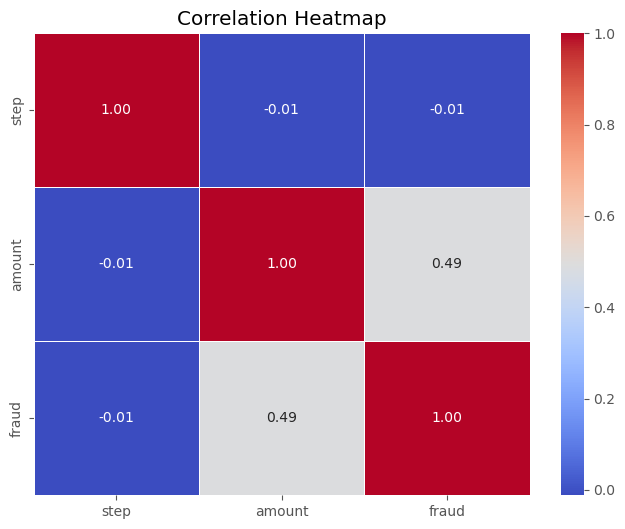

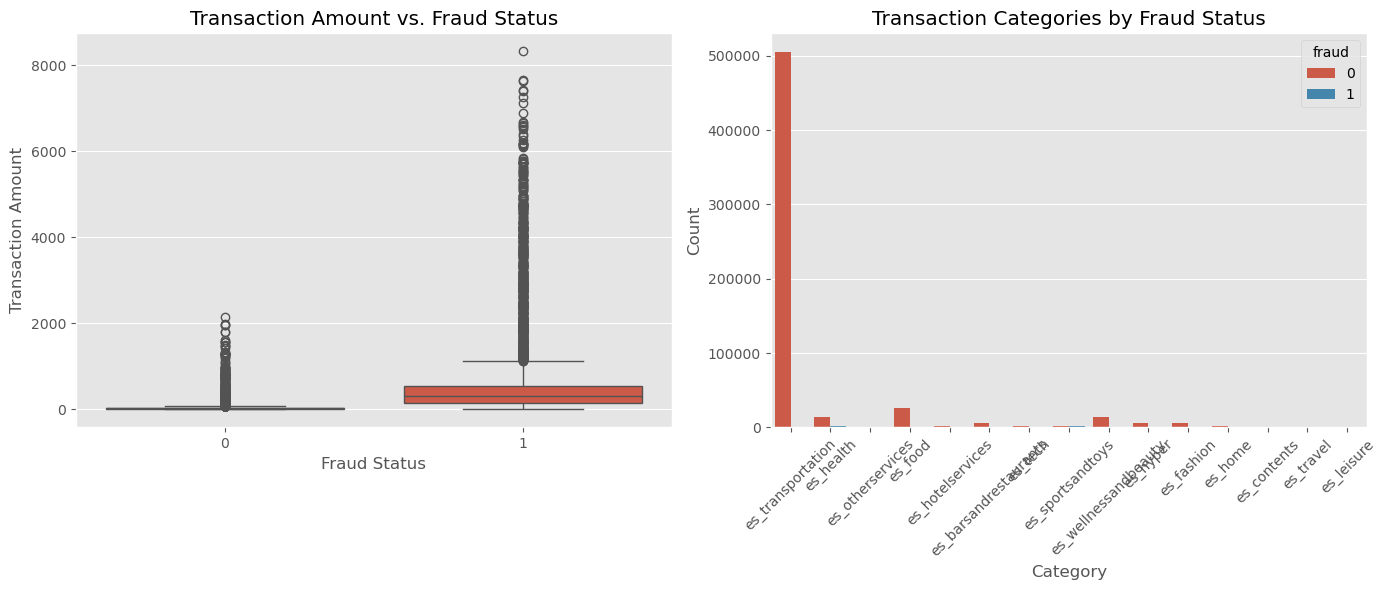

In [28]:
# Setting up the correlation heatmap for numerical variables
fig, ax = plt.subplots(figsize=(8, 6))

# Compute the correlation matrix
correlation_matrix = df[['step', 'amount', 'fraud']].corr()

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
ax.set_title('Correlation Heatmap')
plt.show()

# Investigating patterns of fraud in relation to different features
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for 'amount' by 'fraud' status
sns.boxplot(x='fraud', y='amount', data=df, ax=axes[0])
axes[0].set_title('Transaction Amount vs. Fraud Status')
axes[0].set_xlabel('Fraud Status')
axes[0].set_ylabel('Transaction Amount')

# Count plot for 'category' with hue 'fraud'
sns.countplot(x='category', hue='fraud', data=df, ax=axes[1])
axes[1].set_title('Transaction Categories by Fraud Status')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

plt.tight_layout()
plt.show()


The correlation heatmap analyzed the relationships between step, amount, and fraud in the transaction data. Key findings include:
- Step and Amount: Show a very low correlation, indicating no significant linear relationship over time.
- Step and Fraud: Also exhibit minimal correlation, suggesting fraud occurrences are not tied to specific time steps.
- Amount and Fraud: Display a moderate positive correlation, indicating that higher transaction amounts are more likely to be associated with fraud.

This analysis highlights that while time factors (step) do not significantly influence transaction amounts or fraud occurrences, the transaction amount is a relevant predictor of fraud, underscoring the importance of monitoring larger transactions more closely in fraud detection efforts.

For the 2 other plots:
- Transaction Amount vs. Fraud Status: The box plot illustrates that fraudulent transactions tend to have higher transaction amounts compared to non-fraudulent ones, which could be a significant indicator in identifying fraud.
- Transaction Categories by Fraud Status: This count plot shows how the frequency of transactions varies by category and fraud status. Some categories appear more susceptible to fraud than others, which is important for developing targeted fraud detection strategies.

### Categorical vs Numerical

I would normally use box plots to explore categorical vs numerical relationships, but given the context of needing to understand detailed behaviors within the data, particularly in assessing fraud, violin plots are generally more informative for this dataset. They provide a fuller picture of the transaction amounts across different categories and how those distributions differ between fraudulent and non-fraudulent transactions.


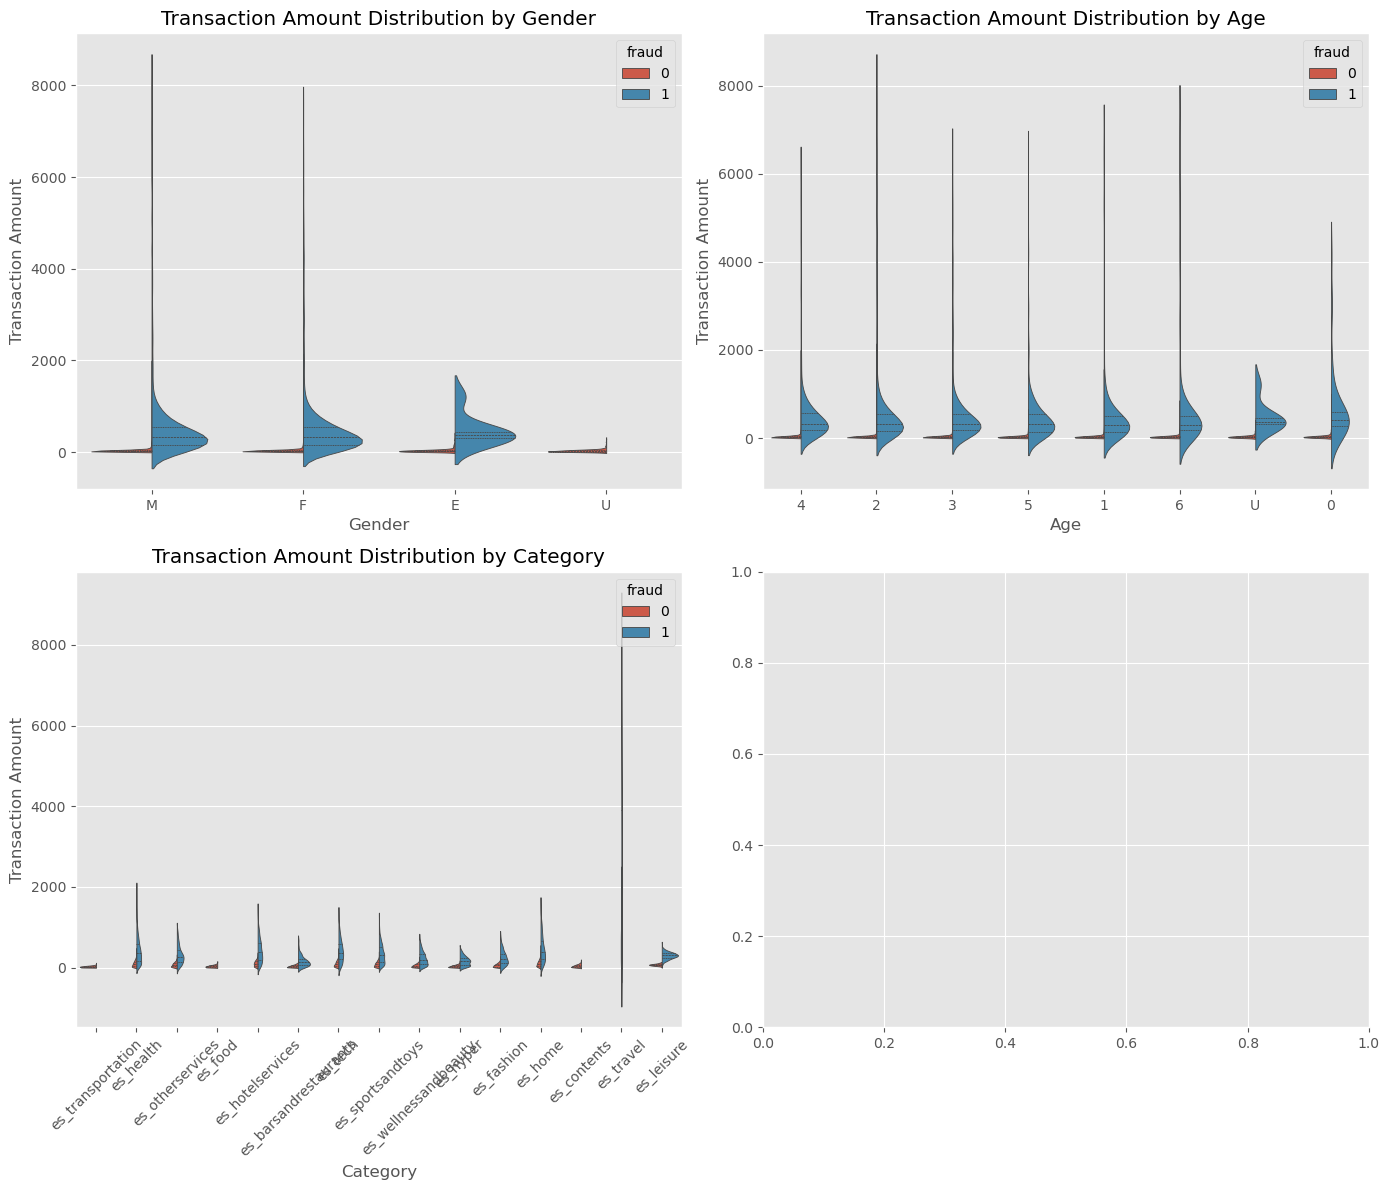

In [32]:
# Setting up a larger plotting area for multiple plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Violin plot for 'amount' across different 'gender' categories
sns.violinplot(x='gender', y='amount', hue='fraud', data=df, split=True, inner='quartile', ax=axes[0, 0])
axes[0, 0].set_title('Transaction Amount Distribution by Gender')
axes[0, 0].set_xlabel('Gender')
axes[0, 0].set_ylabel('Transaction Amount')

# Violin plot for 'amount' across different 'age' categories
sns.violinplot(x='age', y='amount', hue='fraud', data=df, split=True, inner='quartile', ax=axes[0, 1])
axes[0, 1].set_title('Transaction Amount Distribution by Age')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Transaction Amount')

# Violin plot for 'amount' across different 'category' categories
sns.violinplot(x='category', y='amount', hue='fraud', data=df, split=True, inner='quartile', ax=axes[1, 0])
axes[1, 0].set_title('Transaction Amount Distribution by Category')
axes[1, 0].set_xlabel('Category')
axes[1, 0].set_ylabel('Transaction Amount')
axes[1, 0].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Preparing to handle 'merchant' and 'customer' in subsequent plots due to their volume.


The violin plots for gender, age, and category are displayed above, providing detailed insights into the distribution of transaction amounts within these categories, split by fraud status:
- Gender: Shows how transaction amounts are distributed across genders. Both fraudulent and non-fraudulent transactions are represented, indicating typical transaction sizes and the spread for both.
- Age: Different age groups display varying patterns in transaction amounts, with the fraudulent transactions typically showing higher amounts across most age categories.
- Category: Each category has distinct characteristics in terms of transaction amount distributions, with fraud typically occurring at higher transaction amounts in many categories.

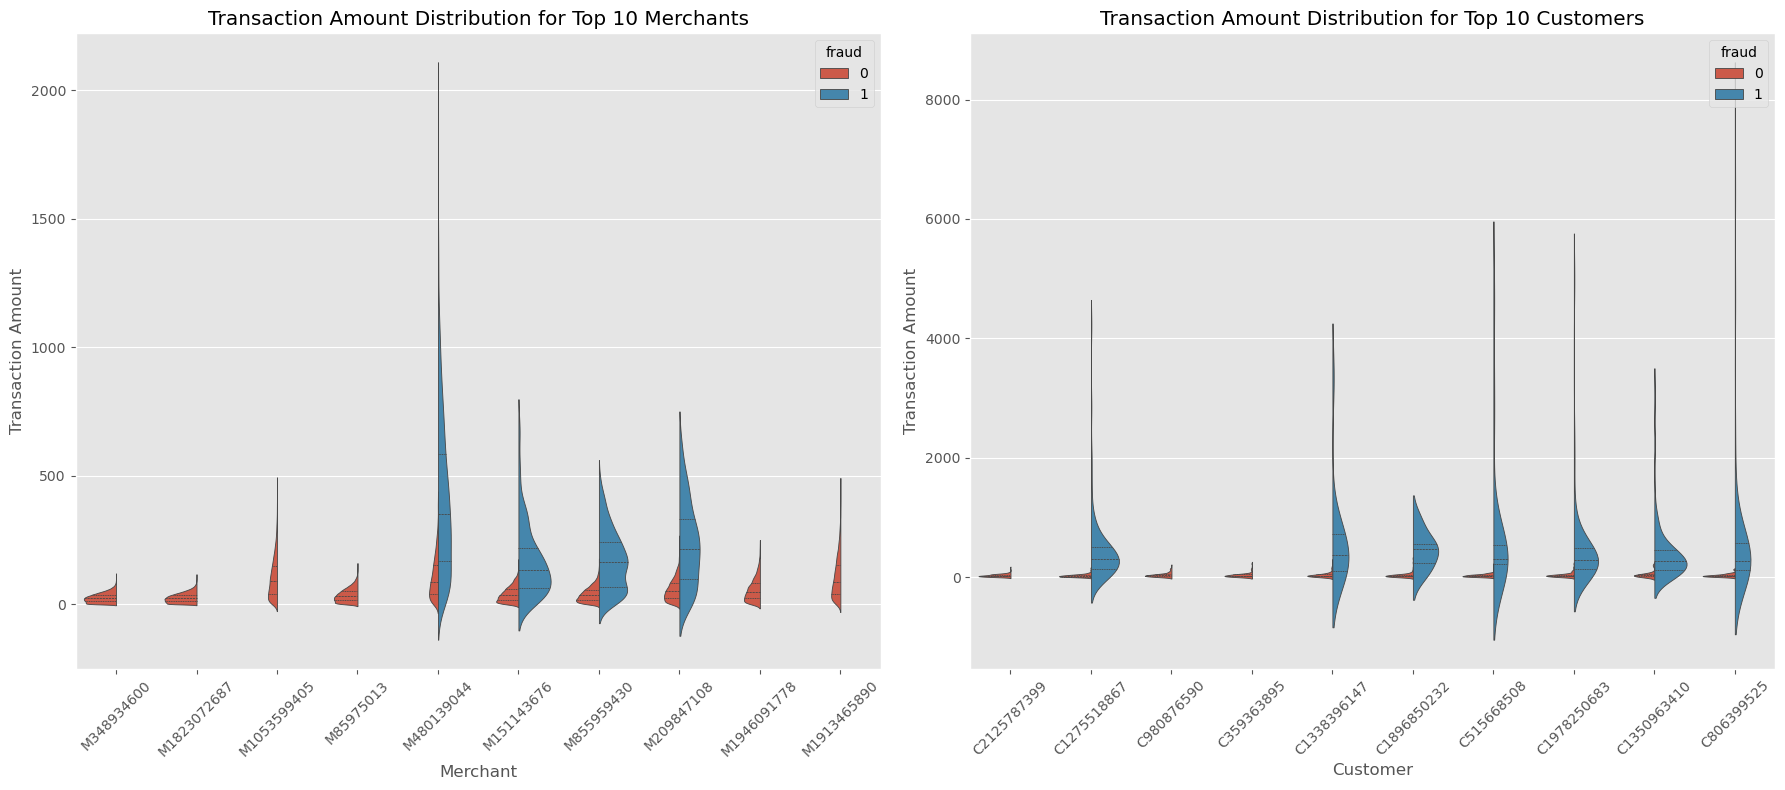

In [34]:
# Identify top 10 merchants and customers by volume
top_merchants = df['merchant'].value_counts().nlargest(10).index
top_customers = df['customer'].value_counts().nlargest(10).index

# Create filtered dataframes
df_top_merchants = df[df['merchant'].isin(top_merchants)]
df_top_customers = df[df['customer'].isin(top_customers)]

# Setting up a figure for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Violin plot for top 10 merchants
sns.violinplot(x='merchant', y='amount', hue='fraud', data=df_top_merchants, split=True, inner='quartile', ax=axes[0])
axes[0].set_title('Transaction Amount Distribution for Top 10 Merchants')
axes[0].set_xlabel('Merchant')
axes[0].set_ylabel('Transaction Amount')
axes[0].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

# Violin plot for top 10 customers
sns.violinplot(x='customer', y='amount', hue='fraud', data=df_top_customers, split=True, inner='quartile', ax=axes[1])
axes[1].set_title('Transaction Amount Distribution for Top 10 Customers')
axes[1].set_xlabel('Customer')
axes[1].set_ylabel('Transaction Amount')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

plt.tight_layout()
plt.show()



# NEED TO DOCUMENT ABOVE GRAPHS

### Behaviors over Time

To explore transaction behavior over time, we'll focus on the step variable. Analyzing this will help us understand trends, patterns, and anomalies over the specified time frame.

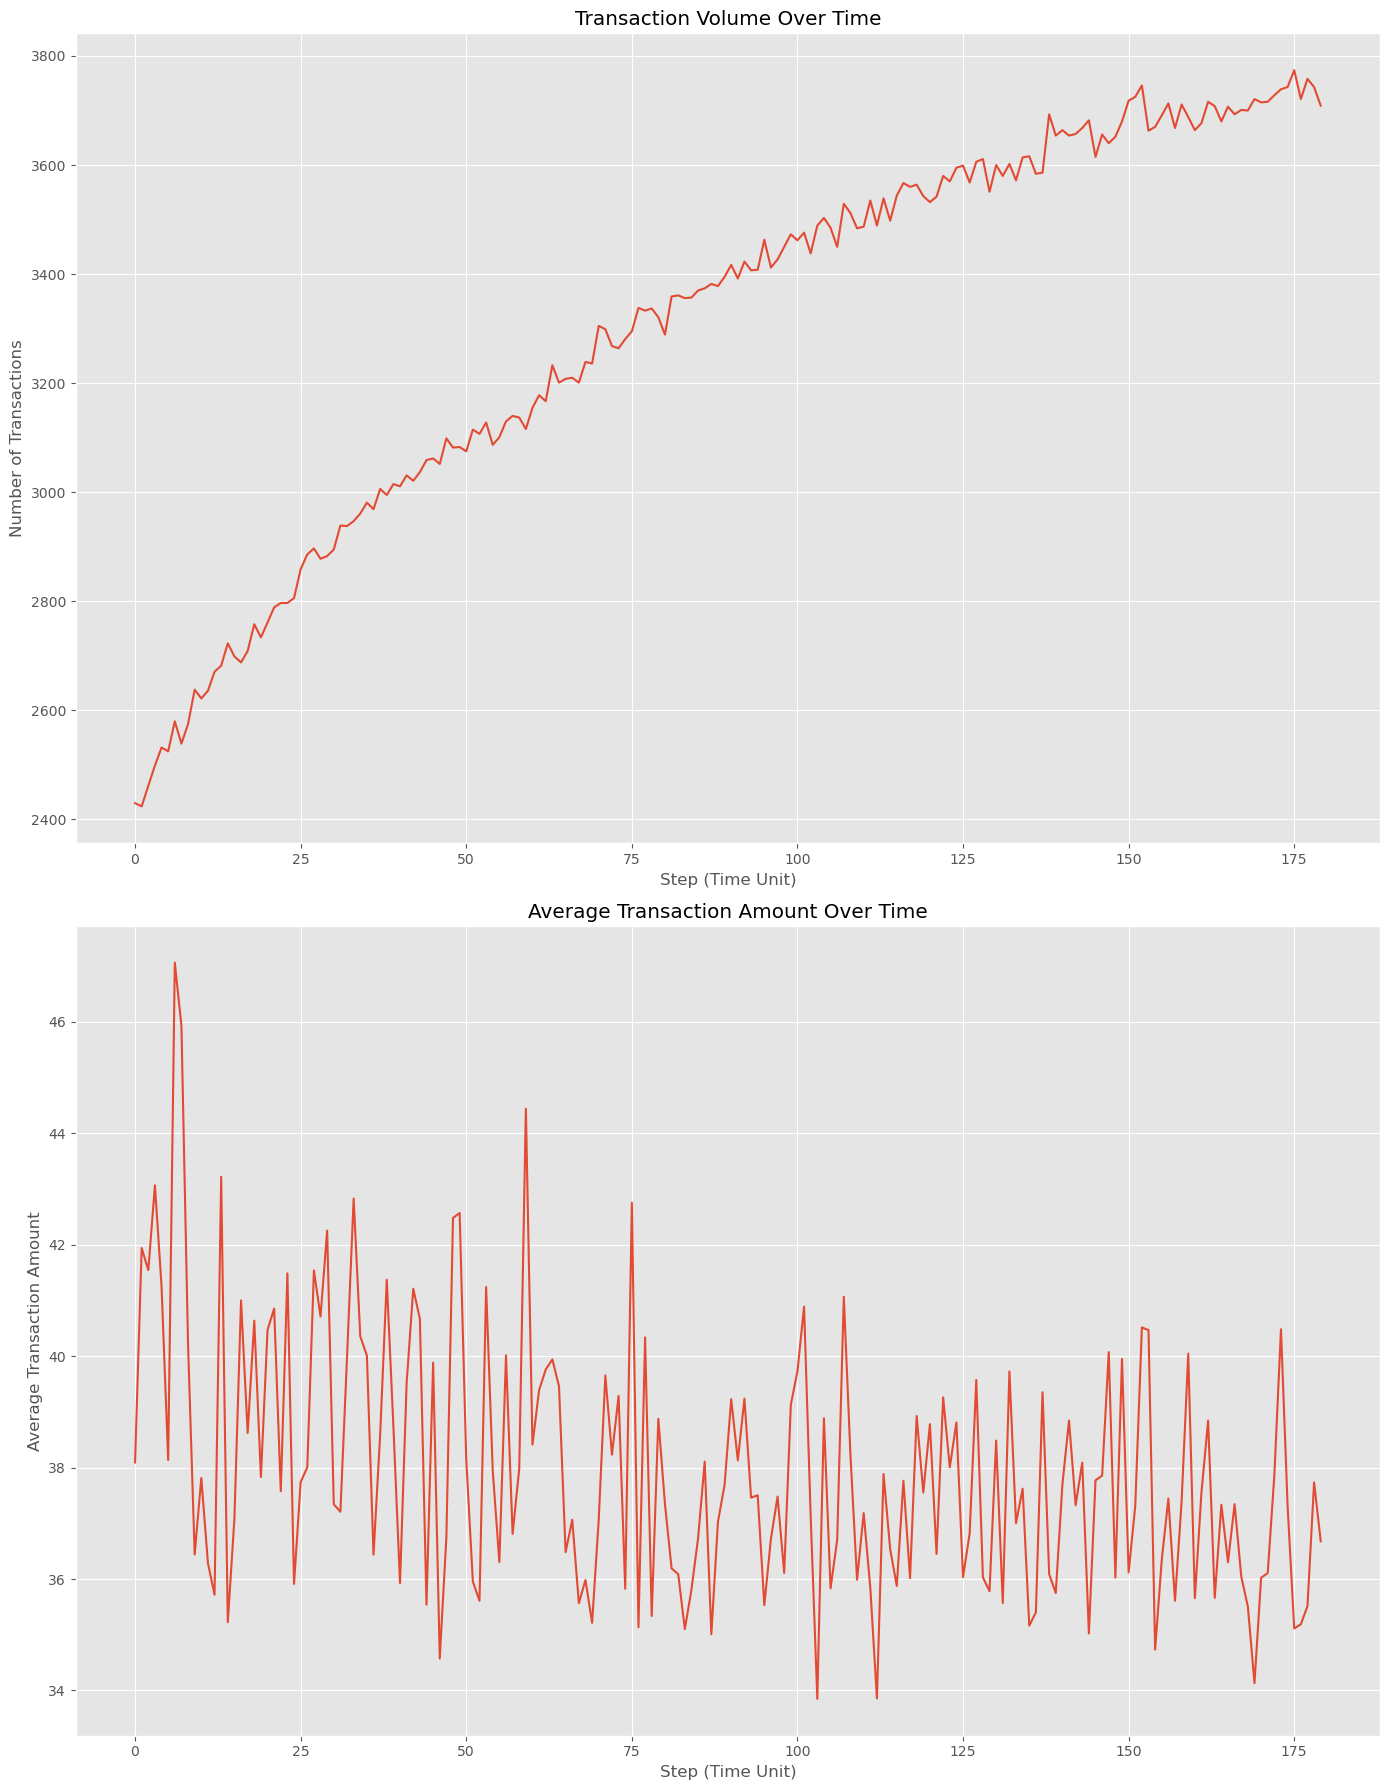

In [36]:
import numpy as np

# Group data by 'step' to summarize the information
time_grouped = df.groupby('step').agg({
    'amount': ['count', 'mean'],  # Count for volume and mean for average amount
    'fraud': ['sum']  # Sum of fraud occurrences
})

# Rename columns for easier understanding
time_grouped.columns = ['Transaction_Count', 'Average_Amount', 'Fraud_Count']
time_grouped.reset_index(inplace=True)

# Plotting the behavior over time
fig, axes = plt.subplots(2, 1, figsize=(14, 18))

# Transaction Volume Over Time
sns.lineplot(x='step', y='Transaction_Count', data=time_grouped, ax=axes[0])
axes[0].set_title('Transaction Volume Over Time')
axes[0].set_xlabel('Step (Time Unit)')
axes[0].set_ylabel('Number of Transactions')

# Average Transaction Amount Over Time
sns.lineplot(x='step', y='Average_Amount', data=time_grouped, ax=axes[1])
axes[1].set_title('Average Transaction Amount Over Time')
axes[1].set_xlabel('Step (Time Unit)')
axes[1].set_ylabel('Average Transaction Amount')

plt.tight_layout()
plt.show()


Here are the plots depicting transaction behaviors over time based on the step variable:

- Transaction Volume Over Time: The first plot shows the number of transactions over each time unit (step). This can help us see overall activity patterns, including any periodic trends or anomalies in transaction volume.
- Average Transaction Amount Over Time: The second plot tracks the average transaction amount per time step. Fluctuations in this metric could indicate changes in purchasing behavior or potential shifts in fraudulent activity, especially if there are significant deviations from the norm.


# Model Preparation

In [39]:
'''
# Use only if I need to reset tuner

import shutil

# Directory where the tuner data is stored
#tuner_directory = 'C:/Users/trobb/GitHub/Projects/timothyrobbinscpa/fraud_analysis/src/my_dir/keras_tune_nn'
tuner_directory = 'C:/Users/trobb/GitHub/Projects/timothyrobbinscpa/fraud_analysis/src/hyperparam_tuning/neural_network_tuning'

# Remove the directory to reset the tuner
shutil.rmtree(tuner_directory, ignore_errors=True)

'''

"\n\nimport shutil\n\n# Directory where the tuner data is stored\n#tuner_directory = 'C:/Users/trobb/GitHub/Projects/timothyrobbinscpa/fraud_analysis/src/my_dir/keras_tune_nn'\ntuner_directory = 'C:/Users/trobb/GitHub/Projects/timothyrobbinscpa/fraud_analysis/src/hyperparam_tuning/neural_network_tuning'\n\n# Remove the directory to reset the tuner\nshutil.rmtree(tuner_directory, ignore_errors=True)\n\n"

In [40]:
class F1Score(tf.keras.metrics.Metric):
    """
    Custom implementation of the F1 Score as a Keras metric. The F1 Score is the harmonic mean of precision and recall,
    providing a balance between the two metrics. It is particularly useful when dealing with imbalanced datasets.
    
    Attributes:
        true_positives (tf.Variable): Tracks the number of true positives encountered over all batches.
        false_positives (tf.Variable): Tracks the number of false positives encountered over all batches.
        false_negatives (tf.Variable): Tracks the number of false negatives encountered over all batches.
    """

    def __init__(self, name='f1_score', **kwargs):
        """
        Initializes the F1Score metric instance.
        
        Args:
            name (str, optional): Name of the metric instance, defaults to 'f1_score'.
            **kwargs: Arbitrary keyword arguments, passed to the parent class.
        """
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Updates the state of the metric, accumulating the true positives, false positives, and false negatives 
        predictions based on the input labels and predictions.
        
        Args:
            y_true (tf.Tensor): The ground truth labels.
            y_pred (tf.Tensor): The predicted labels.
            sample_weight (tf.Tensor, optional): Optional weighting of each example, defaults to None.
        """
        y_pred = tf.round(y_pred)  # Convert probabilities to binary values (0 or 1)
        y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32 to match y_pred data type
        tp = tf.reduce_sum(y_true * y_pred)  # Calculate true positives
        fp = tf.reduce_sum(y_pred) - tp  # Calculate false positives
        fn = tf.reduce_sum(y_true) - tp  # Calculate false negatives

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        """
        Computes and returns the F1 Score using the current state of the metric.
        
        Returns:
            tf.Tensor: The computed F1 Score.
        """
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        """
        Resets all of the metric state variables to zero.
        This function is called at the start of each epoch.
        """
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)



In [41]:
# Separating the target variable 'fraud' from the feature set.
y = df['fraud']  # Target variable for prediction.
X = df.drop('fraud', axis=1)  # Feature set excluding the target.

# Identifying types of columns for preprocessing:
# - Categorical columns are identified by their data type ('object' or 'category').
# - Numerical columns are identified by data types 'int64' or 'float64', excluding the 'fraud' column.
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns.tolist() if col != 'fraud']


In [42]:
# Configure preprocessing for the neural network. This includes:
# - Standardizing numerical columns to have zero mean and unit variance.
# - One-hot encoding categorical columns to convert them into a format suitable for neural network training.
# Unspecified columns are dropped to ensure the model only trains on relevant features.
nn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Normalize numerical data.
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)  # Encode categorical data.
    ],
    remainder='drop'  # Drop other columns not specified explicitly.
)

# Apply the preprocessing transformations to the data, preparing it for the neural network.
X_nn_processed = nn_preprocessor.fit_transform(X)


In [43]:
# Preprocessing for Random Forest:
# Label encoding is applied to categorical columns to transform them into numerical values that the model can interpret.
X_rf = X.copy()  # Create a copy of the original feature set to modify for the Random Forest model.
for col in categorical_cols:
    le = LabelEncoder()
    X_rf[col] = le.fit_transform(X_rf[col])  # Encode each categorical column with label encoding.

# Apply standard scaling to numerical features to normalize their values, which helps in stabilizing the model training.
scaler = StandardScaler()
X_rf[numerical_cols] = scaler.fit_transform(X_rf[numerical_cols])  # Scale each numerical column.



In [44]:
# Split the preprocessed data into training and testing sets for neural network and random forest models.
# Both splits use a test size of 20% and a random state for reproducibility.
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn_processed, y, test_size=0.2, random_state=42)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42)

# SMOTE (Synthetic Minority Over-sampling Technique) is applied to address class imbalance by generating synthetic samples.
smote = SMOTE(random_state=42)
X_train_nn_smote, y_train_nn_smote = smote.fit_resample(X_train_nn, y_train_nn)
X_train_rf_smote, y_train_rf_smote = smote.fit_resample(X_train_rf, y_train_rf)


MemoryError: Unable to allocate 14.9 GiB for an array with shape (475714, 4191) and data type float64

# Modeling

## Neural Network Model

In [ ]:
class MyHyperModel(HyperModel):
    """
    A custom hypermodel class using Keras Tuner for optimizing a neural network model for binary classification.
    
    Attributes:
        input_shape (int): The shape of the input data that the model will accept.
    """

    def __init__(self, input_shape):
        """
        Initializes the hypermodel with the required input shape for the neural network.
        
        Args:
            input_shape (int): The number of features in the input dataset.
        """
        self.input_shape = input_shape

    def build(self, hp):
        """
        Builds and compiles a neural network model with hyperparameters that can be tuned.
        
        Args:
            hp (HyperParameters): A set of hyperparameters provided by Keras Tuner to optimize the model.
        
        Returns:
            model (tf.keras.Model): The compiled neural network model.
        """
        model = Sequential([
            Dense(units=hp.Int('units', min_value=128, max_value=512, step=32), activation='relu', input_shape=(self.input_shape,)),
            Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
            Dense(units=hp.Int('units_2', min_value=64, max_value=256, step=32), activation='relu'),
            Dropout(hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1)),
            Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='binary_crossentropy',
            metrics=[F1Score(), Precision(name='precision'), Recall(name='recall')]
        )
        return model

# Instantiate the hypermodel for the neural network.
hypermodel = MyHyperModel(input_shape=X_train_nn_smote.shape[1])


In [ ]:
np.random.seed(42)  # Set numpy random seed
tf.random.set_seed(42)  # Set TensorFlow random seed

# Setup the Keras Tuner for hyperparameter optimization using the RandomSearch algorithm.
# The goal is to maximize the validation F1 score, limiting the search to a single trial for quick testing.
tuner = RandomSearch(
    hypermodel,
    objective=Objective('val_f1_score', direction='max'),  # Maximize F1 score
    max_trials=20,  # Run 20 sets of hyperparameter values
    executions_per_trial=1,  # Execute the model once per trial
    directory='hyperparam_tuning',
    project_name='neural_network_tuning'
)

# Configure early stopping to prevent overfitting by monitoring the validation F1 score.
early_stopper = EarlyStopping(
    monitor='val_f1_score',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restores model weights from the epoch with the best value of the monitored quantity
    mode='max'  # The monitoring metric is expected to be maximized
)

# Perform the hyperparameter search over the training data with a validation split.
tuner.search(
    X_train_nn_smote, y_train_nn_smote,
    epochs=10,  # Limited number of epochs for quick iteration
    validation_split=0.2,  # 20% of the training data is used as validation data
    callbacks=[early_stopper]
)

# Retrieve the best model from the tuning session.
best_model = tuner.get_best_models(num_models=1)[0]



In [ ]:
# Fit the best model on the training data with validation using the test set.
history = best_model.fit(
    X_train_nn_smote, y_train_nn_smote,
    epochs=15,  # Number of epochs to train the model
    validation_data=(X_test_nn, y_test_nn),
    callbacks=[early_stopper]
)

# Evaluate the neural network model on the test data.
nn_predictions = (best_model.predict(X_test_nn) > 0.5).astype(int)  # Binary classification threshold
nn_prob_predictions = best_model.predict(X_test_nn).ravel()  # Probability predictions

# Print classification metrics and ROC-AUC score for model evaluation.
print("Neural Network Classification Report:\n", classification_report(y_test_nn, nn_predictions))
print("Neural Network ROC-AUC Score:", roc_auc_score(y_test_nn, nn_prob_predictions))


In [ ]:
import matplotlib.pyplot as plt

# Adjust the figure size to better accommodate two plots side by side
plt.figure(figsize=(12, 5))  # Wider figure to prevent squeezing of plots

# Plot for training and validation loss
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for F1 Score during training
plt.subplot(1, 2, 2)  # One row, two columns, second plot
plt.plot(history.history['f1_score'], label='Train F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.title('F1 Score During Training')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## Random Forest Model

In [ ]:
from sklearn.metrics import f1_score, make_scorer

# Create a custom scorer object that measures the F1 score for RF Model:
# The `make_scorer` function converts the `f1_score` metric into a scorer that can be used with scikit-learn's model evaluation and parameter tuning tools.
# The F1 score is a harmonic mean of precision and recall and is particularly useful for evaluating models on imbalanced datasets.
f1_scorer = make_scorer(f1_score)


In [ ]:
# Initialize Random Forest classifier.
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid that RandomizedSearchCV will explore during tuning.
param_grid = {
    'n_estimators': randint(100, 300),  # Number of trees in the forest: increases model complexity and accuracy.
    'max_features': ['sqrt', 'log2'],   # Number of features to consider for the best split: helps in reducing overfitting.
    'max_depth': randint(10, 40),       # Maximum depth of each tree: controls overfitting by limiting how deep trees can grow.
    'min_samples_split': randint(2, 10),# Minimum number of samples required to split an internal node: higher numbers reduce model complexity.
    'min_samples_leaf': randint(1, 4),  # Minimum number of samples required at a leaf node: prevents overfitting on very small leaf sizes.
    'bootstrap': [True, False],          # Method for sampling data points (with or without replacement).
    'class_weight': ['balanced', 'balanced_subsample']  # Handling class imbalance.

}


# Setup RandomizedSearchCV with the defined grid and a focus on maximizing the F1 score.
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings sampled.
    cv=3,      # Number of folds in cross-validator.
    scoring=f1_scorer,  # Custom F1 scorer defined earlier to optimize for F1 score.
    verbose=1, # Controls the verbosity: the higher, the more messages about the process.
    random_state=42,
    n_jobs=-1  # Use all available cores to perform the computations.
)

# Fit the RandomizedSearchCV to the SMOTE-enhanced training data to find the best parameters.
rf_random_search.fit(X_train_rf_smote, y_train_rf_smote)

# Retrieve the best estimator from the search.
best_rf = rf_random_search.best_estimator_

# Make predictions using the best Random Forest model found.
rf_predictions = best_rf.predict(X_test_rf)
rf_prob_predictions = best_rf.predict_proba(X_test_rf)[:, 1]

# Output the classification report and ROC-AUC score for the Random Forest model.
print("Random Forest Classification Report:\n", classification_report(y_test_rf, rf_predictions))
print("Random Forest ROC-AUC Score:", roc_auc_score(y_test_rf, rf_prob_predictions))


In [ ]:
# After fitting the Random Forest model:
rf_feature_importances = best_rf.feature_importances_

rf_feature_names = best_rf.feature_names_in_



# Model Results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Define the performance metrics for comparison.
metrics = ['Precision', 'Recall', 'F1 Score', 'ROC AUC']

# Compute scores for the Neural Network model.
nn_scores = [
    precision_recall_fscore_support(y_test_nn, nn_predictions, average='binary')[0],  # Precision
    precision_recall_fscore_support(y_test_nn, nn_predictions, average='binary')[1],  # Recall
    precision_recall_fscore_support(y_test_nn, nn_predictions, average='binary')[2],  # F1 Score
    roc_auc_score(y_test_nn, nn_prob_predictions)  # ROC AUC
]

# Compute scores for the Random Forest model.
rf_scores = [
    precision_recall_fscore_support(y_test_rf, rf_predictions, average='binary')[0],  # Precision
    precision_recall_fscore_support(y_test_rf, rf_predictions, average='binary')[1],  # Recall
    precision_recall_fscore_support(y_test_rf, rf_predictions, average='binary')[2],  # F1 Score
    roc_auc_score(y_test_rf, rf_prob_predictions)  # ROC AUC
]

# Setup for plotting the comparison.
x = np.arange(len(metrics))  # Label locations for metrics
width = 0.35  # Width of the bars

# Create a figure and a set of subplots.
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nn_scores, width, label='Neural Network')  # Bars for Neural Network
rects2 = ax.bar(x + width/2, rf_scores, width, label='Random Forest')   # Bars for Random Forest

# Add some text for labels, title, and custom x-axis tick labels.
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc='best')

# Add text annotations above each bar for clarity.
def add_value_labels(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(ax, rects1)
add_value_labels(ax, rects2)

# Improve the layout to make room for the tick labels.
fig.tight_layout()

# Display the plot.
plt.show()


Metrics Analysis in Fraud Detection Context:
- Precision:
    - Neural Network: 0.89
    - Random Forest: 0.63
    
Precision measures the proportion of actual fraud cases among the cases flagged as fraud by the model. The Neural Network has a higher precision, indicating it has fewer false positives compared to the Random Forest. This means the Neural Network is better at ensuring legitimate transactions are not incorrectly flagged as fraud.

- Recall:
    - Neural Network: 0.67
    - Random Forest: 0.89
    
Recall measures the proportion of actual fraud cases that the model correctly identifies. The Random Forest has a higher recall, suggesting it catches more fraudulent transactions compared to the Neural Network. High recall is crucial in fraud detection to ensure that fraudulent activities are identified and not missed.

- F1 Score:
    - Neural Network: 0.77
    - Random Forest: 0.74
    
The F1 Score is the harmonic mean of precision and recall, providing a balance between the two. The Neural Network has a slightly higher F1 Score, indicating a better balance between precision and recall in this context.

- ROC AUC:
    - Neural Network: 1.00
    - Random Forest: 0.99
    
ROC AUC measures the model's ability to distinguish between fraudulent and non-fraudulent transactions across all classification thresholds. Both models have very high ROC AUC scores, indicating excellent performance in distinguishing between the two classes. The Neural Network has a slightly higher score, suggesting it is marginally better at distinguishing fraudulent transactions from legitimate ones.

Best for Fraud Detection:

The Random Forest model performs better in terms of recall, indicating it is more effective at identifying a higher number of fraud cases, even if it means catching some false positives.



## PR ROC Curve

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Assuming 'nn_prob_predictions' are the prediction probabilities for the positive class from the Neural Network model
# and 'rf_prob_predictions' are the prediction probabilities for the positive class from the Random Forest model.
# Also assuming 'y_test_nn' is the actual labels for the test dataset used for both models.

# Calculate the precision-recall curve and AUC for the Neural Network
nn_precision, nn_recall, _ = precision_recall_curve(y_test_nn, nn_prob_predictions)
nn_auc = auc(nn_recall, nn_precision)

# Calculate the precision-recall curve and AUC for the Random Forest
rf_precision, rf_recall, _ = precision_recall_curve(y_test_rf, rf_prob_predictions)
rf_auc = auc(rf_recall, rf_precision)

# Plotting the Precision-Recall curves
plt.figure(figsize=(8, 6))
plt.plot(nn_recall, nn_precision, label=f'Neural Network (PR AUC = {nn_auc:.4f})', linestyle='-', linewidth=2)
plt.plot(rf_recall, rf_precision, label=f'Random Forest (PR AUC = {rf_auc:.4f})', linestyle='--', linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Precision-Recall Curve Comparison

In fraud detection, selecting a model that balances precision and recall effectively is vital. These metrics ensure that the model can detect as many fraud cases as possible (high recall), while minimizing the number of legitimate transactions that are incorrectly flagged as fraudulent (high precision).

**Importance of Precision and Recall in Fraud Detection**
- **Recall (Sensitivity):** This metric measures the model's ability to detect all actual fraud cases. High recall is crucial because the cost of missing a fraudulent transaction can be significant, potentially leading to financial losses and damaging customer trust.
- **Precision:** This metric indicates the proportion of transactions flagged as fraudulent that are actually fraudulent. Maintaining high precision is important to prevent customer dissatisfaction and operational inefficiencies that arise from handling false positives.

**Analysis of the PR Curve**
- **Overall Performance:** The Random Forest model shows a higher Area Under the Curve (AUC) of 0.8730 compared to the Neural Network's AUC of 0.8523, suggesting better overall performance in balancing precision and recall.
- **Behavior at Different Recall Levels:**
  - At lower recall levels, both models start with high precision, which is beneficial for scenarios that require maintaining high precision even if it means sacrificing some recall.
  - As recall increases, precision generally decreases for both models due to the inclusion of more challenging negative cases as positives.
  - The Random Forest maintains higher precision across most recall levels compared to the Neural Network, indicating it can detect more fraud cases without significantly increasing false positives.

**Choosing the Right Model**
- **Random Forest:** With its higher AUC and ability to maintain higher precision at comparable recall levels, the Random Forest model is more suitable for fraud detection. It effectively balances the need to catch fraud cases and minimize false positives, helping to minimize financial losses and maintain customer trust.
- **Neural Network:** Although slightly less effective in this specific comparison, Neural Networks may still be preferred in contexts where model interpretability is less critical and capturing complex patterns that Random Forests might miss is necessary.

**Conclusion**
- In fraud detection systems, choosing a model that achieves the highest possible recall without unduly sacrificing precision is crucial. The Random Forest model, with its superior performance on the PR curves, appears to be the better choice, offering an optimal trade-off between detecting frauds and minimizing disturbances to legitimate customers.







## Cumulative Gain Curve

In [ ]:
# pip install scikit-plot

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# Assuming you have the actual labels 'y_test_nn' and 'y_test_rf'
# and the prediction probabilities 'nn_prob_predictions' and 'rf_prob_predictions'

# For scikit-plot, we need to stack the probabilities of the negative and positive classes
# If you only have the probabilities for the positive class, you can construct the required format like this:
nn_prob_predictions_stacked = np.vstack((1-nn_prob_predictions, nn_prob_predictions)).T
rf_prob_predictions_stacked = np.vstack((1-rf_prob_predictions, rf_prob_predictions)).T

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Cumulative Gain Curve for Neural Network on the first subplot
skplt.metrics.plot_cumulative_gain(y_test_nn, nn_prob_predictions_stacked, ax=ax1)
ax1.set_title('Cumulative Gains Curve - Neural Network')

# Plot Cumulative Gain Curve for Random Forest on the second subplot
skplt.metrics.plot_cumulative_gain(y_test_rf, rf_prob_predictions_stacked, ax=ax2)
ax2.set_title('Cumulative Gains Curve - Random Forest')

# Show plot with tight layout
plt.tight_layout()
plt.show()



## Cumulative Gains Curves Interpretation

The following analysis explores how the Cumulative Gains Curves for the Neural Network and Random Forest models enhance fraud detection strategies by effectively identifying fraudulent transactions.

**Cumulative Gains Curve Analysis - Neural Network**
- **Performance Insight**: The immediate and sharp rise in the blue curve for Class 1 shows the Neural Network's high effectiveness in recognizing the most probable fraudulent transactions early in the sample.
- **Fraud Detection Implications**: Such an early identification capability is crucial in fraud detection, allowing for rapid and focused investigation on high-risk transactions, thereby minimizing resource expenditure and enhancing operational efficiency.

**Cumulative Gains Curve Analysis - Random Forest**
- **Performance Insight**: The curve for the Random Forest displays a similar pattern to the Neural Network, with a rapid initial rise that indicates strong performance in early fraud detection.
- **Fraud Detection Implications**: This model's ability to quickly pinpoint a large percentage of fraudulent activities early in the process means that fewer transactions need intensive review, improving the speed and effectiveness of fraud prevention measures.

**Efficiency and Operational Benefits**
- **Detection Efficiency**: Both models demonstrate their ability to detect fraudulent transactions at the beginning of the sample, crucial for preventing further fraudulent activity.
- **Operational Efficiency**: By effectively identifying most fraud cases early, these models allow organizations to concentrate efforts and resources on the most suspicious transactions, reducing unnecessary reviews and accelerating response times.
- **Baseline Performance Comparison**: Compared to the baseline, represented by the dashed line indicating random transaction review, both models significantly advance the detection capabilities, particularly in the critical early stages.

**Concluding Remarks**
The Cumulative Gains Curves for both models affirm their value in fraud detection systems. They optimize the process by ensuring that the majority of fraudulent transactions are identified quickly, enabling organizations to allocate resources more efficiently and respond more swiftly to potential threats. This capability is essential for maintaining financial security and consumer trust in high-risk environments.


## Feature Importances

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'rf_feature_importances' and 'rf_feature_names' are already defined

# Create a sorted list of feature importances and corresponding names from largest to smallest
sorted_indices = np.argsort(rf_feature_importances)[::-1]  # Get the indices to sort in descending order
sorted_importances = np.array(rf_feature_importances)[sorted_indices]
sorted_names = np.array(rf_feature_names)[sorted_indices]

x = np.arange(len(sorted_importances))  # positions for the Random Forest bars
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rf_bars = ax.bar(x, sorted_importances, width, label='Random Forest')

ax.set_ylabel('Feature Importance Score')
ax.set_title('Random Forest Feature Importances')
ax.set_xticks(x)
ax.set_xticklabels(sorted_names, rotation=45)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rf_bars)

fig.tight_layout()
plt.show()


## Feature Importances for Fraud Detection

The bar chart illustrates the importance of various features in a Random Forest model used for fraud detection. The significance of each feature is quantified by the model based on how much each feature contributes to improving the model's accuracy and decision-making process.

**Feature Importance Overview**
- **Amount**: The feature 'amount' has the highest importance score of 0.445, indicating that the transaction amount is the most significant predictor of fraudulent activity. This suggests that larger transactions are potentially more likely to be fraudulent, or that fraudsters tend to manipulate transaction amounts more significantly.
  
- **Category**: The second most important feature is 'category' with a score of 0.297. This reflects that the type or category of the transaction also plays a critical role in detecting fraud. Certain categories may be more prone to fraud than others, making this feature crucial for identifying risky transactions.
  
- **Merchant**: The feature 'merchant' shows an importance score of 0.201, placing it as the third most significant predictor. This could imply that transactions involving certain merchants or merchant categories are more likely to be associated with fraud.
  
- **Customer**: With a much lower importance score of 0.018, 'customer' details also contribute to the model, albeit to a much lesser extent. This might indicate that while customer-specific patterns can signal fraudulent activity, they are not as strong predictors as the amount, category, or merchant.
  
- **Gender**: Gender has an importance score of 0.016, suggesting minimal impact on fraud detection. It appears that gender is not a significant determinant of fraudulent behavior in this model.
  
- **Step**: The 'step' feature, representing the time aspect of transactions, has a similar score to gender, 0.016. This indicates that the timing of the transaction, while relevant, is not among the most critical features.
  
- **Age**: Finally, 'age' has the lowest importance score of 0.007, showing that it has little influence on predicting fraud in this model context.

**Conclusion**

The feature importance graph from the Random Forest model provides valuable insights into which factors are most influential in predicting fraudulent transactions. The prominence of 'amount', 'category', and 'merchant' underscores their importance in any fraud detection system. Understanding these key drivers can help in developing more targeted fraud prevention strategies, focusing on the most indicative signs of fraudulent activity.


## Business Recommendations for Enhancing Fraud Detection Systems

The analysis of feature importances from the Random Forest model, alongside the performance metrics of both Neural Network and Random Forest models, offers several actionable business recommendations to enhance fraud detection capabilities.

**Prioritize High-Impact Features**
- **Transaction Amount**: Implement automated monitoring systems to flag transactions that exceed predefined thresholds based on historical data and typical customer behavior. This can help in quickly identifying and scrutinizing potentially fraudulent large transactions.
- **Transaction Category and Merchant Analysis**: Develop specialized monitoring rules for categories and merchants identified as higher risk. This could involve more frequent reviews, tighter transaction controls, or automated alerts when transactions in these categories or with these merchants occur.

**Leverage Early Detection**
- **Focus on Early Detection in Transaction Monitoring**: Utilize the capability of models to detect fraud early in the transaction process. By setting up systems to prioritize reviews of alerts generated from the most predictive features early, resources can be allocated more effectively, enhancing the speed and accuracy of fraud detection efforts.

**Enhance Customer Engagement and Education**
- **Customer Notifications**: Implement real-time notification systems to alert customers of suspicious activities immediately. This not only helps in quick fraud mitigation but also engages customers in securing their transactions.
- **Educational Campaigns**: Run periodic customer education campaigns about common fraud scenarios and safe transaction practices, particularly focusing on the most vulnerable transaction categories and merchants.

**Conclusion**
- By focusing on these strategic areas, businesses can significantly enhance the effectiveness of their fraud detection systems.

In [ ]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total runtime of the program is {total_time/(60 * 60)} hours")
